In [16]:
import pandas as pd
import scipy
import numpy as np
from scipy import spatial
import matplotlib
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv("all_manually_annotated.csv", index_col=0)

In [18]:
import string

def remove_punc(text):
    return "".join([char for char in text if char not in string.punctuation])

df.sentence1 = df.sentence1.apply(lambda x: x.lower())
df.sentence1 = df.sentence1.apply(lambda x: " ".join(remove_punc(x).split()))
df.sentence2 = df.sentence2.apply(lambda x: x.lower())
df.sentence2 = df.sentence2.apply(lambda x: " ".join(remove_punc(x).split()))

In [4]:
df_pos = df.loc[df["class"] == 1]
df_neg = df.loc[df["class"] == 0]
df_neg

,class,word,sentence1,sentence2
0,0,kap,prostituiranjem občasno je počel tudi to me je...,kapa gre v pariz
2,0,kap,odgovor ne sme vas presenetiti in vas zadeti u...,je avgusta 2009 med potapljanjem na hrvaškem z...
3,0,kap,piva ki naj bi ga spil pahor skoraj kap,od jeze si je strojevodja snel z glave železni...
4,0,kap,smučarske čevlje hlače bundo rokavice in vtakn...,imk ishemična možganska kap ali infarkt
5,0,kap,moškega nižje postave v temno oblečenega s tem...,reakcijo na osvetlitev težko je oceniti ali je...
...,...,...,...,...
546,0,vila,ena najponosnejših stavb ki še sanja o pretekl...,vile pripovedujejo o odgovornosti avtor besedila
552,0,vila,na odseku kozina–ankaran kjer so novoodkrite o...,ki je trdil da je tudi sam že videl vile se je...
554,0,vila,vendar steza pod strmo zaporo še zadnjič zavij...,starejše deklice se že rade oblečejo v princes...
556,0,vila,tisto grozno jutranje vstajanje … in so se v v...,je dobrodelno društvo ki so ga ustanovile štir...


In [19]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("w2v/model.bin", binary=True)

In [6]:
neg_diff = []
pos_diff = []

for i in df_pos.index:
    p1 = df_pos.sentence1[i].split(" ")
    p2 = df_pos.sentence2[i].split(" ")
    one = []
    two = []
    for i in range(len(p1)):
        try:
            one.append(model[p1[i]])
        except KeyError:
            pass
    for i in range(len(p2)):
        try:
            two.append(model[p2[i]])
        except KeyError:
            pass

    t1 = np.mean(one, axis=0)
    t2 = np.mean(two, axis=0)
    pos_diff.append(spatial.distance.cosine(t1, t2))

for i in df_neg.index:
    p1 = df_neg.sentence1[i].split(" ")
    p2 = df_neg.sentence2[i].split(" ")
    one = []
    two = []
    for i in range(len(p1)):
        try:
            one.append(model[p1[i]])
        except KeyError:
            pass
    for i in range(len(p2)):
        try:
            two.append(model[p2[i]])
        except KeyError:
            pass

    t1 = np.mean(one, axis=0)
    t2 = np.mean(two, axis=0)
    neg_diff.append(spatial.distance.cosine(t1, t2))

In [15]:
y = np.asarray([neg_diff, pos_diff], dtype=np.float32)
print(np.mean(pos_diff, axis=0))
print(max(pos_diff))
print(min(pos_diff))
print()
print(np.mean(neg_diff, axis=0))
print(max(neg_diff))
print(min(neg_diff))

0.2358053836416691
0.5756661891937256
0.0844888687133789

0.2827901497800299
0.7266395092010498
0.10914385318756104


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

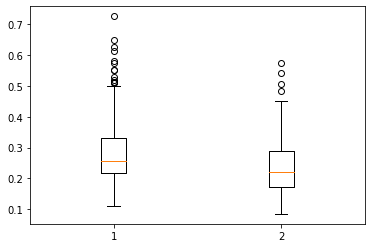

In [12]:
plt.boxplot([neg_diff, pos_diff])
plt.errorbar(2, np.mean(y, axis=0), yerr=np.std(y, axis=0))
plt.show()

In [20]:
cls = []

for row in df.index:
    p1 = df.sentence1[row].split(" ")
    p2 = df.sentence2[row].split(" ")
    one = []
    two = []
    for i in range(len(p1)):
        try:
            one.append(model[p1[i]])
        except KeyError:
            pass
    for i in range(len(p2)):
        try:
            two.append(model[p2[i]])
        except KeyError:
            pass
    t1 = np.mean(one, axis=0)
    t2 = np.mean(two, axis=0)
    res = spatial.distance.cosine(t1, t2)
    if res < 0.25:
        cls.append(1)
    else:
        cls.append(0)

(0.599798374393548, 0.6024316109422493, 0.5942702088723418, None)


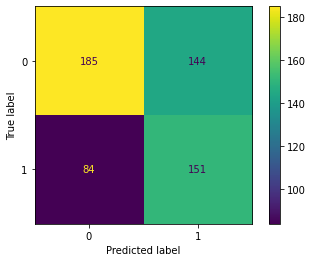

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt

base = df["class"]
classes = [0,1]
c = metrics.confusion_matrix(base, cls, labels=classes)
disp = metrics.ConfusionMatrixDisplay(c, display_labels=classes)
disp.plot()
print(metrics.precision_recall_fscore_support(base, cls, average="macro"))
plt.savefig("cm_w2v.jpg")